In [1]:
from collections import Counter
import itertools

import pandas as pd
import numpy as np

import matplotlib.pylab as plt
%matplotlib inline

from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc

In [2]:
bad_cntr = pd.read_csv('../data/yarobl_bad_contracts_plus.csv')
good_cntr = pd.read_csv('../data/yaroblmz_good_contracts.csv')
data = bad_cntr.append(good_cntr)
data = data.dropna()
print(data.shape)

(11862, 15)


In [3]:
X = data.iloc[:,1:-1]
y = data.cntr_result.values

In [4]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [5]:
random_forest = RandomForestClassifier(n_estimators=20)

In [6]:
y_train_real = np.array([])
y_test_real = np.array([])

y_train_pred = np.array([])
y_test_pred = np.array([])
y_test_pred_proba = np.zeros((0, 2))

In [7]:
for train_index, test_index in KFold(n_splits=10).split(X):
    X_train = X[train_index]
    X_test = X[test_index]
    
    y_train = y[train_index]
    y_test = y[test_index]
    
    random_forest.fit(X_train, y_train)
    
    y_train_real = np.concatenate((y_train_real, y_train))
    y_test_real = np.concatenate((y_test_real, y_test))
    
    y_train_pred = np.concatenate((y_train_pred, random_forest.predict(X_train)))
    y_test_pred = np.concatenate((y_test_pred, random_forest.predict(X_test)))
    y_test_pred_proba = np.concatenate((y_test_pred_proba, random_forest.predict_proba(X_test))) 

In [8]:
print('Точность %s на обучающей выборке' % accuracy_score(y_train_real, y_train_pred))
print('Точность %s на тестовой выборке' % accuracy_score(y_test_real, y_test_pred))
print('Потеря перекрестной энтропии %s\n' % log_loss(y_test_real[:len(y_test_pred_proba)], y_test_pred_proba))
print(classification_report(y_test_real, y_test_pred, target_names=('Плохой', 'Хороший')))

Точность 0.996225107252 на обучающей выборке
Точность 0.778114989041 на тестовой выборке
Потеря перекрестной энтропии 0.71984713437

             precision    recall  f1-score   support

     Плохой       0.78      0.77      0.78      5926
    Хороший       0.77      0.79      0.78      5936

avg / total       0.78      0.78      0.78     11862



In [9]:
def plot_confusion_matrix(
    cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues
):
   
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [10]:
def plot_dependence(res):
    counter0 = Counter() # счетчик плохих контрактов
    counter1 = Counter() # счетчик хороших контрактов

    for index, row in res.iterrows():
        proba = round(row['proba_pred'], 2)

        if not row['result']:
            counter0[proba] += 1
        else:
            counter1[proba] += 1
    
    corr_df0 = pd.DataFrame.from_dict(counter0, orient='index').reset_index().sort_values(['index'])
    corr_df1 = pd.DataFrame.from_dict(counter1, orient='index').reset_index().sort_values(['index'])
    
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)

    ax.plot(corr_df0['index'], corr_df0[0])
    ax.plot(corr_df1['index'], corr_df1[0])

    plt.legend(['Плохие контракты', 'Хорошие контракты'], loc='upper left')
    plt.xlabel('Предсказываемая вероятность плохого исхода')
    plt.ylabel('Реальное количество контрактов')
    plt.title('Корреляция proba_pred_bad и result')
    plt.show()

In [11]:
def plot_roc_curve(y_test_real, y_test_pred):
    fpr, tpr, threshold = roc_curve(y_test_real, y_test_pred)
    roc_auc = auc(fpr, tpr)

    plt.title('ROC')
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    plt.plot([0, 1], [0, 1],'r--', label='Удача')
    plt.legend(loc='lower right')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [12]:
res = pd.DataFrame({'result': y_test_real}).join(
    pd.DataFrame({'proba_pred': y_test_pred_proba[:,0]}).join(
        pd.DataFrame({'pred': y_test_pred})
    )
)

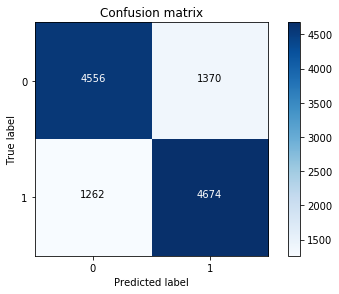

In [13]:
plot_confusion_matrix(confusion_matrix(y_test_real, y_test_pred), (0, 1))

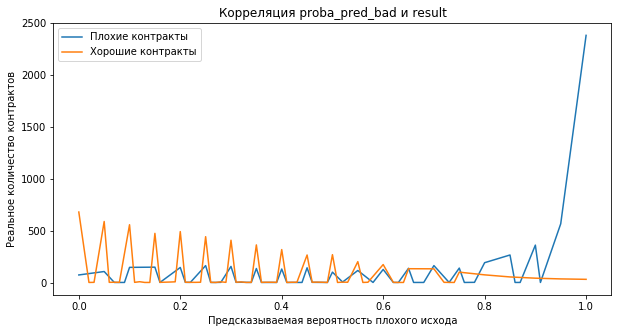

In [14]:
plot_dependence(res)

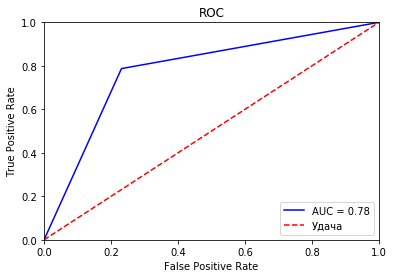

In [15]:
plot_roc_curve(y_test_real, y_test_pred)